Project: Analyzing NYC High School Data

the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic datasets. During some of the other lessons, we combined the following datasets into a single, clean pandas dataframe:


SAT scores by school - SAT scores for each high school in New York City

School attendance - Attendance information for each school in New York City

Class size - Information on class size for each school

AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)

Graduation outcomes - The percentage of students who graduated and other outcome information

Demographics - Demographic information for each school

School survey - Surveys of parents, teachers, and students at each school


New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

This project is an investigation into relationships between demographics and SAT scores i

# Read in the data

In [13]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

READ IN THE SURVEYS


In [14]:

all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

Read in the surveys

In [15]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

Add DBN columns

In [16]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

Convert columns to numeric

In [17]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

Condense datasets

In [18]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

Convert AP scores to numeric

In [19]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

Combine the datasets

In [20]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

Add a school district column for mapping

In [21]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

Find correlations

In [22]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


In [23]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
import matplotlib.pyplot as plt
%matplotlib inline
sat_survey_corr = combined.corr()

sat_survey_corr = sat_survey_corr.loc[survey_fields, 'sat_score']

print(sat_survey_corr)

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


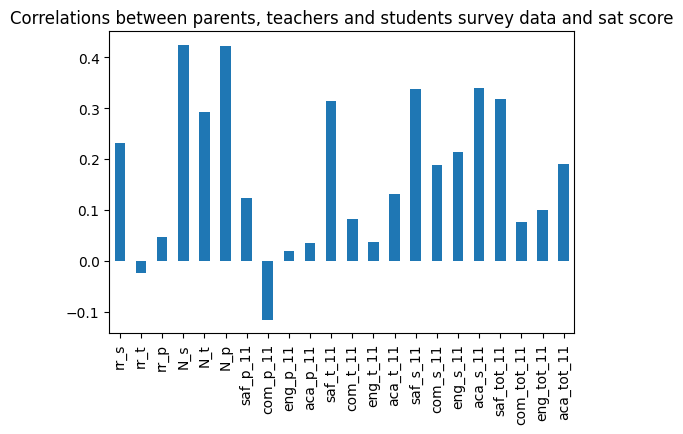

In [24]:
sat_survey_corr.plot.bar( title = 'Correlations between parents, teachers and students survey data and sat score')

plt.show()

Exploring Safety and SAT Scores

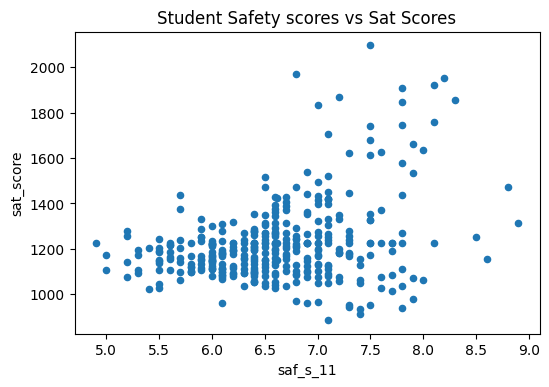

In [25]:

combined.plot.scatter(x= 'saf_s_11', y = 'sat_score', title = 'Student Safety scores vs Sat Scores')
plt.show()

In [26]:
#Safety score by borough - 'boro'
combined_b = combined.groupby('boro')

sat_borough = combined_b.agg('mean')

sat_borough = sat_borough['saf_s_11']

print(sat_borough)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


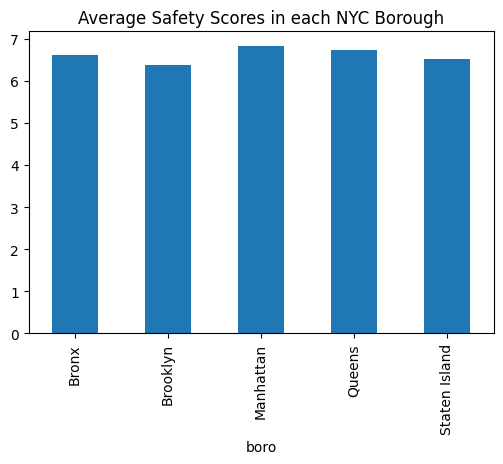

In [27]:
sat_borough.plot.bar(title = 'Average Safety Scores in each NYC Borough')

plt.show()

Exploring Race and SAT Scores

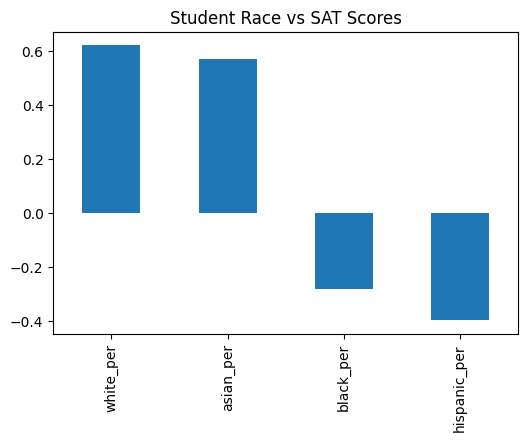

In [28]:

race_sat = combined[['white_per', 'asian_per', 'black_per', 'hispanic_per', 'sat_score']]
race_corr = race_sat.corr()
race_corr = race_corr.loc[['white_per', 'asian_per', 'black_per', 'hispanic_per']]

race_corr_sat = race_corr['sat_score']
race_corr_sat.plot.bar(title = 'Student Race vs SAT Scores')
plt.show()

The bar plot shows us that white and asian students are more likely to perform better on the sat than black and hispanics. This was expected as black and hispanic communities are more prone to come from an emporvrished background not enabling to hire tutors or sometimes need to work outside of school to support their family.

Exploring Schools with low SAT Scors and high hispanic students

In [ ]:

combined.plot.scatter(x= 'hispanic_per', y = 'sat_score', title = 'SAT Scores vs hispanic_per')

plt.show()

We notice from the plot above that low sat scores correlate with high percentage of hispanic students. This supports the correlation coefficient of -0.4 calculated when exploring each student race and average sat_scores


In [ ]:

school_hisp_m95 = combined['hispanic_per'] > 95

print(combined['SCHOOL NAME'][school_hisp_m95])

In [ ]:
school_hisp_m95 = combined['hispanic_per'] < 10

school_sat_low1800 = combined['sat_score'] > 1800

print(combined['SCHOOL NAME'][school_hisp_m95 & school_sat_low1800])

In [ ]:
gender_sat = combined[['male_per','female_per', 'sat_score']]

gender_corr = gender_sat.corr()

gender_corr = gender_corr.loc[['male_per','female_per'], ['sat_score']]

print(gender_corr)

In [ ]:
gender_corr.plot.bar(title = 'SAT Score and Gender correlations')

plt.show()

The bar pot above shows us that the percentage of female students has a positive correlation with higher sat scores, whereas the percentage of male students in negatively correlated, meaning that more male students has lower sat scores


In [ ]:

print(combined['sat_score'].value_counts())

print(combined['female_per'].value_counts())

# assuming high sat scores is >1000 and high female % above 80

In [ ]:
bool_fem = combined['female_per'] > 80
bool_sat = combined['sat_score'] > 1000

combined_fem_sat = combined[bool_fem & bool_sat]

combined_fem_sat.plot.scatter(x= 'female_per', y='sat_score', title = 'female_per vs sat_score')

plt.show()

The female_per vs sat_score for schools with high values in both variables does not provide a conclusive result. There aren't any data points and the scatter plot shows a weak positive correlation, which matches the correlation coefficient of 0.1 that was previously calculated.


In [ ]:

#explore schools with female_per > 60 and sat score > 1700
bool_fem = combined['female_per'] > 60
bool_sat = combined['sat_score'] > 1700

combined_fem_sat1 = combined[bool_fem & bool_sat]

print(combined_fem_sat1[['SCHOOL NAME']])

Exploring AP Scores vs. SAT Scores

In [ ]:

#Percentage of students in each school that took an AP exam

combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined_ap_sat = combined[['ap_per', 'sat_score']]

combined_ap_sat.plot.scatter(x='ap_per', y ='sat_score', title = 'AP Test Takers per school vs SAT Scores')

plt.show()

The AP Test takers percentage vs SAT scores scatter plot shows that the majority of data points are in the lower ranges. There is no clear correlation, after ap_per of 0.2, a portion of schools see an increase in SAT scores with increased number of AP test takers, however, the majority of remaining data points remain somewhat constant between